In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as stats
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;

from sklearn.feature_selection import RFE
# from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import learning_curve, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### В данном ноутбуке представлен процесс построения скоркарты, но с использованием дополнительных видов моделей:
- DecisionTree (дерево решений)
- RandomForest (классический случайный лес, объединение деревьев решений)
- LinearTree (дерево решений с логистической регрессией в листе)

Основное отличие по сравнению с классическим способом - способ преобразования модели в SQL.

In [2]:
# !pip install mlxtend
# !pip install lightgbm
# !pip install pymysql
# !pip install scikit-plot
# !pip install tqdm

# Дополнительные библиотеки для преобразования моделей в SQL:
# !pip install sqlparse
# !pip install skompiler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from autoscoring import IDF
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning, correct_binning_dict, print_feature_bins
from autoscoring.sql_converter import convert_linear_tree_to_sql, convert_model_to_sql
from autoscoring.AS_models import *

In [25]:
df = pd.read_excel('data/slkz_SolvaStreet.xlsx', sheet_name='result 1')

# Добавить, если имя целевой переменной отличается от 'target'
# df['target'] = 

# df['date_requested'] = pd.to_datetime(df['date_requested'])
DATE = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df[DATE] = pd.to_datetime(df[DATE])
df_req = df[['credit_id', DATE]]
df['y'] = df['target']
y = df.y

In [ ]:
# В некоторых случаях при загрузке из excel файла может произойти проблема,
# связанная с тем, что в excel вещественные числа разделяются запятой,
# а в python разделение идёт по точке.
# Если возникла такая проблема, то можно заменить все запятые на точки и сделать преобразование типовю

# Запускать эту ячейку, только если есть данная проблема. Иначе можно пропустить.

# for col in df.select_dtypes(include=object).columns:
#     df[col] = df[col].apply(lambda x: str(x).replace(',', '.'))

# df = df.apply(pd.to_numeric, errors='ignore')

In [27]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCORE' in var or 'scoring' in var or 'street' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

In [28]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
# Можно задать список признаков, который не будет учавствовать в предобработке
ignore_vars = ['date_requested', 'credit_id', 'target', DATE]
df, else_df = replace_not_frequent_2(df, cat_vars, num_min=min_num, ignore_vars=ignore_vars)

# Drop columns with only 1 value
df = drop_single_value_column(df, except_cols=ignore_vars)

In [29]:
# Если вы не разделяете сэмпл на df_out, то можете закомментировать этот кусок,
# и вместо него запустить:
# df_out, y_out = None, None

df_out = df[df['date_requested'] >= '2021-01-01']
df = df[df['date_requested'] < '2021-01-01']
y_out = df_out.y

In [30]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.2, stratify=df.y, random_state=123)

#### Построение WOE таблицы

In [21]:
# Задаём набор признаков для формирования биннинга.
# Набор колонок, который не будет учавствовать в построении карты
technical_features = ['credit_id', 'date_requested', 'type',
                        'target', 'y', DATE]
technical_features = list(set(technical_features))
# Задаём набор признаков, которые будут учавствовать в биннинге,
# для этого удаляем все ненужные признаки из общего списка переменных.
features = df_train.drop(
    technical_features
, axis=1).columns

target_name = 'target'  # Наименование столбца - таргета
# Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# только в исключительных ситуациях
min_bin_size = 0.05
max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# Как определять WOE для пропусков, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
nan_to_woe = 'max_cat'
# Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
else_to_woe = 'max_cat'
# Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
monotonic = False
n_jobs = 4  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df_train, features, target_name,
                                                         max_bin_count=max_bin_count,
                                                         min_bin_size=min_bin_size,
                                                         nan_to_woe=nan_to_woe,
                                                         else_to_woe=else_to_woe,
                                                         monotonic=monotonic,
                                                         n_jobs=n_jobs)

# iv_df - таблицы WOE биннинга
# dropped_feats - набор переменных, для которых биннинг не посчитался,
# т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный,
# также стоит отдельно смотреть, что может быть такая ситуация, что переменная не имеет хорошего 
# разделения, но NaN значения хорошо отделяются. Тогда стоит отдельно заполнять NaN некоторым эмпирическим значением.
# feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# по которым признак не очень хороший, можно игнорировать
# best_features - набор признаков после предварительного отбора внутри AutoML,
# можно использовать при дальнейшем отборе, можно проигнорировать
# auto_woe - техническая переменная, можно игнорировать

[LightGBM] [Info] Number of positive: 474, number of negative: 5268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19198
[LightGBM] [Info] Number of data points in the train set: 5742, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082550 -> initscore=-2.408199
[LightGBM] [Info] Start training from score -2.408199


In [31]:
# Если ранее для скоркарты была создана таблица iv_df, то её можно загрузить из excel.
iv_df = pd.read_excel('result/iv_df.xlsx', index=0)

In [17]:
# Набор обязательных признаков, которые должны остаться несмотря на отбор.
# Если они не нужны, можно оставить пустым или закомментировать.
mandatory_feats = ['credits_active_owner', 'credits_all_owner']
mandatory_feats_woe = ['WOE_' + col for col in mandatory_feats]

In [37]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.05
vars = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()

# Можно закомментировать, если не надо добавлять обязательных признаков. 
# vars = add_mandatory_feats(vars, mandatory_feats)

print(len(vars))

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(vars)]

78


In [38]:
iv_co = None
X_train, y_train = transform_df_to_woe(df_train[vars], y_train, IV, iv_df, iv_cut_off=iv_co)
X_test, y_test = transform_df_to_woe(df_test[vars], y_test, IV, iv_df, iv_cut_off=iv_co)
X_out, y_out = transform_df_to_woe(df_out[vars], y_out, IV, iv_df, iv_cut_off=iv_co)

Features left after IV drop: 78
DONE!
Features left after IV drop: 78
DONE!
Features left after IV drop: 78
DONE!


In [39]:
X_train.columns = 'WOE_' + X_train.columns
X_test.columns = 'WOE_' + X_test.columns
X_out.columns = 'WOE_' + X_out.columns

#### Отбор признаков

##### Т.к. мы не будем использовать логистическую регрессию, а обучим другие модели, то отбор признаков немного меняется. Например нам необязательно отсеивать признаки по корреляциям.

Dropped columns: [] 

Features left after correlation check: 143 

Not dropped columns: ['WOE_cnt_IL_comp_no_Crd', 'WOE_reg', 'WOE_fcb_last_open_d_cr_act', 'WOE_min_all_last_pay', 'WOE_gcvp_type_employee', 'WOE_fc_his_w_pay_st_by_cls_crd_sum', 'WOE_sum_per_cred', 'WOE_sum_all_credit_sum', 'WOE_pti5', 'WOE_r_reg', 'WOE_credit_purpose', 'WOE_avg_fr_age', 'WOE_h_ac_sum_div_h_cl_sum', 'WOE_bor_age', 'WOE_credits_all_owner', 'WOE_enpf_text', 'WOE_capsTotalAmountL1m', 'WOE_exists_income_for_3_month', 'WOE_fcb_first_Cash_credit', 'WOE_cnt_IL_comp', 'WOE_fc_act_div_all_crd', 'WOE_min_IL_planned_close_date', 'WOE_fc_his_w_pay_st_by_act_crd_sum', 'WOE_main_wall_postsN', 'WOE_fc_h_ac_sum_div_days', 'WOE_cnt_IL_past_due_no_Crd', 'WOE_centre_completed', 'WOE_dti5', 'WOE_fc_credits_all_owner', 'WOE_sex', 'WOE_fc_enpf_text', 'WOE_avg_photos_n', 'WOE_io_device_os', 'WOE_capsL1d_v2', 'WOE_fc_h_ac_sum_div_h_cl_sum', 'WOE_cnt_IL_all_no_Crd', 'WOE_fcb_last_open_d_cr_all', 'WOE_h_ac_sum_div_days', 'WOE_req

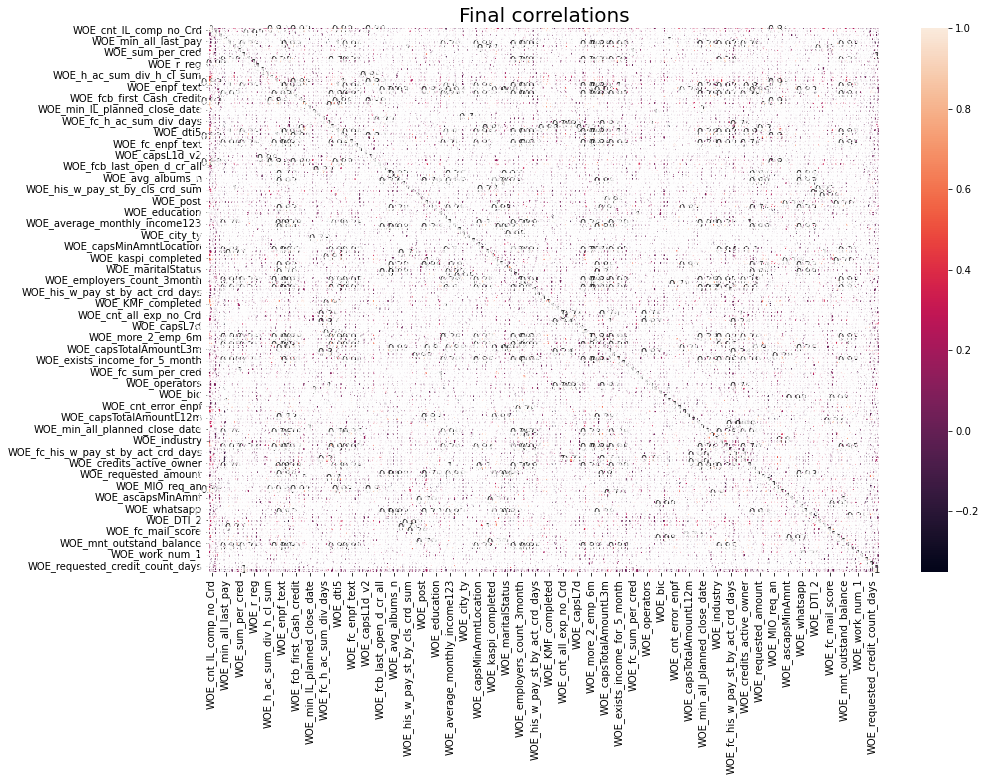

In [21]:
# Устанавливаем порого для фильтрации признаков по корреляциям.
# По дефолту 0.85 - оптимальное значение, в зависимости от требований
# можно поставить число в диапозоне 0.75 - 0.9.

# cut_off = 0.85
# X_train_corr = delete_correlated_features(X_train, cut_off=cut_off, is_plot_prev=False,
#                                           exclude=[], IV_sort=True, iv_df=iv_df)

In [22]:
# corr_feats = X_train_corr.columns

In [40]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по DATE (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества интервалов большего num_bad_intervals.
# Т.е. например, если gini_min=0.05 и num_bad_intervals=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.05  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_intervals = 2  # 2 месяца/недели по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week

gini_feats, df_gini_months = gini_month_selection(X_train, df_train, gini_min=gini_min,
                                                  num_bad_intervals=num_bad_intervals, date_name=date_name,
                                                  intervals=intervals)

In [41]:
print(len(list(gini_feats)))
df_gini_months[df_gini_months['vars'].isin(gini_feats)]

78


,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,WOE_days_from_fc_d_requested,0.047,0.010,0.085,0.114,0.050,0.124,0.101,0.134
1,WOE_credits_active_owner,0.030,0.122,0.166,0.133,0.216,0.101,0.179,0.185
2,WOE_credits_all_owner,0.124,0.039,0.320,0.209,0.268,0.229,0.293,0.390
3,WOE_monthly_instalments_owner,0.020,0.098,0.116,0.214,0.277,0.127,0.222,0.279
4,WOE_mnt_outstand_balance,0.016,0.022,0.090,0.166,0.311,0.149,0.271,0.189
...,...,...,...,...,...,...,...,...,...
73,WOE_industry,0.122,0.155,0.179,0.151,0.207,0.091,0.300,0.266
74,WOE_post,0.057,0.158,0.100,0.187,0.191,0.151,0.278,0.268
75,WOE_work_num_1,-0.018,0.091,0.131,0.130,0.082,0.154,0.249,0.217
76,WOE_work_num_2,0.083,-0.098,0.068,-0.016,0.106,0.124,0.223,0.224


In [43]:
# Отбираем признаки по их значимости во время построения Деревьев решений.
top_n = 50  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
rf_feats, rf_imp = rf_feature_selection(X_train[gini_feats], y_train, top_n=top_n)

In [146]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 35  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
tf_feats, tf_imp = permutation_two_forest_selection(X_train[rf_feats], y_train, top_n=top_n)

##### Так же нам можно брать больше признаков в модель, например 15-30.

In [32]:
# # Делаем итоговый отбор признаков, он вычислительно затратный и более точный.
# n_features = 8  # количество признаков, оптимально 7 - 14, меньше - быстрее посчитается.
# selection_type = 'bf'  # Тип перебора признаков, оптимальный вариант 'bf' можно выбрать 'ALL', если есть время подождать.
# X_train_res, X_test_res, X_train_cp, X_test_cp = feature_selection(X_train[tf_feats], y_train, X_test[tf_feats], y_test,
#                                                  n_features=n_features, selection_type=selection_type)

done included_00
done included_00


In [ ]:
# Сохраянем все пройденные этапы отбора признаков.
selection_stages = {
    'исходный набор': features,
    'WOE биннинг': iv_df['VAR_NAME'].unique(),
    # 'корреляции': corr_feats,
    'однофакторный gini по месяцам': gini_feats,
    'features importance деревьев решений': rf_feats,
    'permutation importance двухлесовый метод': tf_feats,
    # 'отбор функцией feature_selection("bf")': X_train_res.columns,
}
name = 'result/selection_stages.xlsx'
save_selection_stages(selection_stages, name)

In [ ]:
# TODO: добавить какой-нибудь итеративный отбор признаков.

In [147]:
vars_woe = tf_feats
# vars_woe = add_mandatory_feats(vars_woe, mandatory_feats_woe)
print(vars_woe)

['WOE_last_deduction_date' 'WOE_requested_amount_to_pay'
 'WOE_NumberOfOverdueInstalmentsMax' 'WOE_fcb_first_cred_open'
 'WOE_mail_score' 'WOE_cnt_IL_comp' 'WOE_requested_amount'
 'WOE_halyk_completed' 'WOE_PTI_11' 'WOE_cnt_IL_all' 'WOE_maritalStatus'
 'WOE_capsTotalAmountL12m' 'WOE_capsMaxAmnt' 'WOE_home_completed'
 'WOE_cnt_IL_all_no_Crd' 'WOE_fc_mail_score' 'WOE_industry' 'WOE_pti7'
 'WOE_employment' 'WOE_sex' 'WOE_conf_income_per' 'WOE_post'
 'WOE_work_amount' 'WOE_fc_h_cl_sum_div_days' 'WOE_reg' 'WOE_work_num_1'
 'WOE_sum_per_cred' 'WOE_capsTotalAmountL6m' 'WOE_capsTotalAmountL7d'
 'WOE_capsL1d' 'WOE_fc_mnt_outstand_balance' 'WOE_bor_age'
 'WOE_work_num_2' 'WOE_avg_fr_age' 'WOE_r_reg']


In [129]:
vars_woe = """'WOE_last_deduction_date' 'WOE_requested_amount_to_pay'
 'WOE_NumberOfOverdueInstalmentsMax' 'WOE_fcb_first_cred_open'
 'WOE_mail_score' 'WOE_cnt_IL_comp' 'WOE_requested_amount'
 'WOE_halyk_completed' 'WOE_PTI_11' 'WOE_cnt_IL_all' 'WOE_maritalStatus'
 'WOE_capsTotalAmountL12m' 'WOE_capsMaxAmnt' 'WOE_home_completed'
 'WOE_cnt_IL_all_no_Crd' 'WOE_fc_mail_score' 'WOE_industry' 'WOE_pti7'
 'WOE_employment' 'WOE_sex' 'WOE_conf_income_per' 'WOE_post'
 'WOE_work_amount' 'WOE_fc_h_cl_sum_div_days' 'WOE_reg'"""

vars_woe = [var.replace("'", "") for var in vars_woe.split()]

In [148]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

params_forest = {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.05,
                 'class_weight': {0: 1, 1: 4}, 'random_state': 123}
model = RandomForestClassifier(**params_forest)

sfs1 = SFS(deepcopy(model), 
           k_features=20, 
           forward=False, 
           floating=False, 
        #    verbose=2,
           scoring='roc_auc',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train[vars_woe]), y_train)

In [149]:
# X_train[vars_woe].columns[list(sfs1.k_feature_idx_)]
vars_woe = np.array(vars_woe)[list(sfs1.k_feature_idx_)]

In [46]:
# Создаём список переменных, для удобного ручного отбора,
# если ручной отбор не треубется, можно пропустить.
vars_woe = [
    # 'WOE_last_deduction_date',
    # 'WOE_mail_score',
    'WOE_requested_amount_to_pay',
    'WOE_cnt_IL_comp',  
    # 'WOE_work_amount',
    # 'WOE_MIO_req_an',
    'WOE_r_reg',
    'WOE_capsTotalAmountL7d',
    'WOE_NumberOfOverdueInstalmentsMax',
    # 'WOE_DTI_2',
    'WOE_fc_mail_score',
    'WOE_PTI_11',
    'WOE_fcb_first_cred_open_act'
]

#### Обучение модели, требуется выбрать одну из них, а остальные закомментировать.

In [65]:
from autoscoring.lineartree import LinearTreeClassifier
# Для использования модели LinearTree треубется установить дополнительную библиотеку:
# !pip install --upgrade linear-tree

In [187]:
# df_train_m = X_train[vars_woe]
# df_test_m = X_test[vars_woe]
# df_out_m = X_out[vars_woe]

df_train_m = X_train[new_vars_woe]
df_test_m = X_test[new_vars_woe]
df_out_m = X_out[new_vars_woe]


params = {
    'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
    'class_weight': {0: 1, 1: 4}, 'random_state': 142
}
# Обучаем модель на данных полученных после удаления аномалий.
# logreg = LogisticRegression(**params).fit(df_train_m, y_train)

# Требуется закомментировать не нужные модели и оставить только одну выбранную.

# Обучаем дерево решений.
# params_tree = {'max_depth': 8, 'min_samples_leaf': 0.05, 'class_weight': {0: 1, 1: 4},
#                  'random_state': 123}
# model = DecisionTreeClassifier(**params_tree).fit(df_train_m, y_train)

# Обучаем случайный лес.
params_forest = {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.05,
                 'class_weight': {0: 1, 1: 4}, 'random_state': 123}
model = RandomForestClassifier(**params_forest).fit(df_train_m, y_train)

# Обучаем модель LinearTree - дерево решений с логистическими регрессиями в листах.
# params_logreg = {'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
#                  'class_weight': {0: 1, 1: 4}, 'random_state': 142}
# model = LinearTreeClassifier(
#             base_estimator=LogisticRegression(**params_logreg),
#             max_depth=4,
#             min_samples_leaf=0.15,
# ).fit(df_train_m, y_train)


predict_proba_train = model.predict_proba(df_train_m)[:, 1]
predict_proba_test = model.predict_proba(df_test_m)[:, 1]
predict_proba_out = model.predict_proba(df_out_m)[:, 1]

Gini_train = round(2 * roc_auc_score(y_train, predict_proba_train) - 1, 3)
Gini_test = round(2 * roc_auc_score(y_test, predict_proba_test) - 1, 3)
Gini_out = round(2 * roc_auc_score(y_out, predict_proba_out) - 1, 3)

print('---------------------------------------------------------------------------------------------')
print('| Gini train =', Gini_train, '| Gini test =', Gini_test,  '| Gini out =', Gini_out, '|')
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
| Gini train = 0.508 | Gini test = 0.395 | Gini out = 0.346 |
---------------------------------------------------------------------------------------------


In [188]:
new_vars_woe = list(vars_woe).copy()

for i, var in enumerate(vars_woe):
    __model = deepcopy(model)
    __model.fit(X_train[new_vars_woe], y_train)

    predict_proba_train = __model.predict_proba(X_train[new_vars_woe])[:, 1]
    predict_proba_test = __model.predict_proba(X_test[new_vars_woe])[:, 1]

    gini_train = 2 * roc_auc_score(y_train, predict_proba_train) - 1
    gini_test =  2 * roc_auc_score(y_test, predict_proba_test) - 1
    gini_diff_before = (gini_train - gini_test) / gini_test


    __vars_current = np.delete(new_vars_woe, np.where(np.array(new_vars_woe) == var))

    __model = deepcopy(model)
    __model.fit(X_train[__vars_current], y_train)

    predict_proba_train = __model.predict_proba(X_train[__vars_current])[:, 1]
    predict_proba_test = __model.predict_proba(X_test[__vars_current])[:, 1]

    gini_train = 2 * roc_auc_score(y_train, predict_proba_train) - 1
    gini_test =  2 * roc_auc_score(y_test, predict_proba_test) - 1
    gini_diff_after = (gini_train - gini_test) / gini_test

    if gini_diff_before - gini_diff_after >= 0.03:
        new_vars_woe.remove(var)

    # var_to_del = df_var_ginis.iloc[-1]['var_name']
    # new_vars_woe.remove(var_to_del)

In [ ]:
# Надо создать 3 функции:
# - удаление признаков, чтобы уменьшить переобучение
# - оптимизация параметров, чтобы уменьшить переобучение
# - добавление призанков для увеличения gini
# 

In [ ]:
new_vars_woe = list(vars_woe).copy()

for i, var in enumerate(vars_woe):
    __model = deepcopy(model)
    __model.fit(X_train[new_vars_woe], y_train)

    predict_proba_train = __model.predict_proba(X_train[new_vars_woe])[:, 1]
    predict_proba_test = __model.predict_proba(X_test[new_vars_woe])[:, 1]

    gini_train = 2 * roc_auc_score(y_train, predict_proba_train) - 1
    gini_test =  2 * roc_auc_score(y_test, predict_proba_test) - 1
    gini_diff_before = (gini_train - gini_test) / gini_test


    __vars_current = np.delete(new_vars_woe, np.where(np.array(new_vars_woe) == var))

    __model = deepcopy(model)
    __model.fit(X_train[__vars_current], y_train)

    predict_proba_train = __model.predict_proba(X_train[__vars_current])[:, 1]
    predict_proba_test = __model.predict_proba(X_test[__vars_current])[:, 1]

    gini_train = 2 * roc_auc_score(y_train, predict_proba_train) - 1
    gini_test =  2 * roc_auc_score(y_test, predict_proba_test) - 1
    gini_diff_after = (gini_train - gini_test) / gini_test

    if gini_diff_before - gini_diff_after >= 0.03:
        new_vars_woe.remove(var)

    # var_to_del = df_var_ginis.iloc[-1]['var_name']
    # new_vars_woe.remove(var_to_del)

In [189]:
new_vars_woe

['WOE_last_deduction_date',
 'WOE_mail_score',
 'WOE_halyk_completed',
 'WOE_cnt_IL_all',
 'WOE_maritalStatus',
 'WOE_capsTotalAmountL12m',
 'WOE_fc_mail_score',
 'WOE_industry',
 'WOE_sex',
 'WOE_conf_income_per',
 'WOE_work_amount',
 'WOE_fc_h_cl_sum_div_days',
 'WOE_reg',
 'WOE_work_num_1',
 'WOE_sum_per_cred',
 'WOE_capsTotalAmountL7d',
 'WOE_capsL1d',
 'WOE_fc_mnt_outstand_balance',
 'WOE_bor_age',
 'WOE_work_num_2']

In [173]:
var_to_del

'with all'

#### Функции для ручного подбора признаков

In [190]:
# Здесь требуется последовательно указать train, test, out выборки,
# если out - отсутствует, поставить None.
# При этом стоит указать не все признаки, а набор признаков после
# предварительного отбора - rf_feats, gini_feats
X_all = [X_train[rf_feats], X_test[rf_feats], X_out[rf_feats]]
y_all = [y_train, y_test, y_out]

# Считаем, что будет, если убрать один из признаков.
# Напротив каждого признака - gini модели после удаления этого признака.
df_var_ginis = feature_exclude_model(X_all, y_all, list(vars_woe), iv_df, model)
df_var_ginis.sort_values(by='gini_test', ascending=False)

,var_name,gini_train,gini_test,gini_out,IV
20,WOE_work_num_2,0.527045,0.410439,0.324247,0.0584
8,WOE_industry,0.524189,0.405033,0.325113,0.1656
19,WOE_bor_age,0.522235,0.40146,0.312156,0.1815
0,with all,0.508482,0.395087,0.345989,
3,WOE_halyk_completed,0.521095,0.390704,0.341535,0.1366
5,WOE_maritalStatus,0.516166,0.385625,0.333080,0.1085
17,WOE_capsL1d,0.524406,0.38548,0.323624,0.0531
18,WOE_fc_mnt_outstand_balance,0.515175,0.384859,0.309651,0.1297
14,WOE_work_num_1,0.533264,0.384521,0.331815,0.0904
9,WOE_sex,0.528343,0.384215,0.320208,0.0924


In [85]:
# Считаем, что будет, если добавить один из признаков.
# Напротив каждого признака - gini модели после добавления этого признака.
df_var_ginis = feature_include1_model(X_all, y_all, vars_woe, iv_df, model)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

,var_name,gini_train,gini_test,gini_out,IV
35,WOE_h_ac_sum_div_h_cl_sum,0.48259,0.451298,0.426258,0.0566
20,WOE_fc_h_ac_sum_div_h_cl_sum,0.48259,0.451298,0.426258,0.0566
33,WOE_requested_amount,0.478319,0.449779,0.429079,0.1804
23,WOE_capsTotalAmountL1d,0.487506,0.44559,0.410371,0.2171
21,WOE_fc_mnt_outstand_balance,0.479211,0.444176,0.422337,0.1297
32,WOE_mnt_outstand_balance,0.479211,0.444176,0.422337,0.1297
40,WOE_last_deduction_date,0.514296,0.44074,0.398236,0.2448
17,WOE_fc_sum_per_cred,0.484769,0.440667,0.403814,0.1236
15,WOE_sum_per_cred,0.484769,0.440667,0.403814,0.1236
14,WOE_mail_score,0.489317,0.439084,0.417237,0.1662


#### Построение графиков и таблиц для оценки результатов

In [87]:
_X = np.vstack([X_train[vars_woe], X_test[vars_woe], X_out[vars_woe]])
_y = np.hstack([y_train, y_test, y_out])

_model = deepcopy(model)
scores = list(map(lambda x: round(x, 3), 2 * cross_val_score(_model, _X, _y, cv=5, scoring='roc_auc') - 1))
print ('Cross_val_scores: ', scores)

Cross_val_scores:  [0.464, 0.474, 0.413, 0.444, 0.458]


In [91]:
date_name = DATE  # имя столбца даты по которому делить на месяцы
intervals = 'month'  # грануляция по времени, возможно month и week

# TODO: сделать функцию construct_df3, которая будет работать с кастомной моделью.
df3 = construct_df3_bbox(vars_woe, model, X_train, X_test, df_train, df_test,
                         X_out=X_out, df_out=df_out, date_name=date_name, intervals=intervals)

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

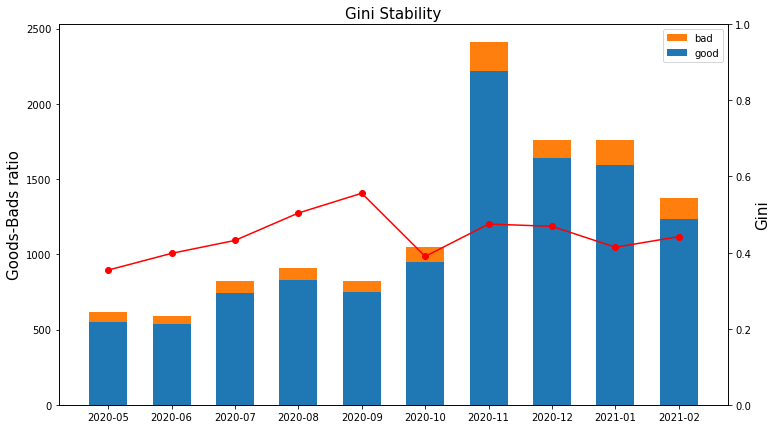

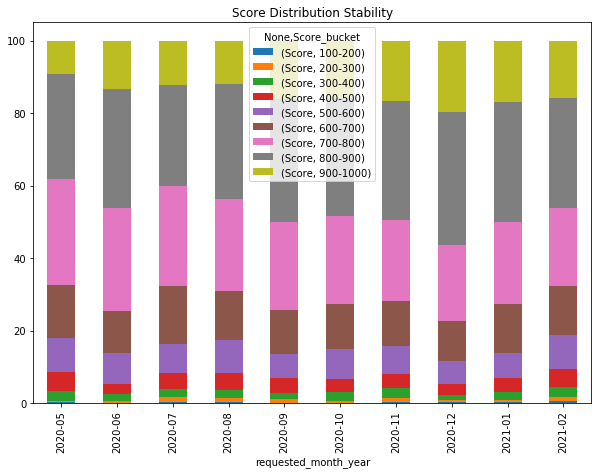

In [92]:
Ginis = create_gini_stability(df3, model, X_train[vars_woe])

pic_folder = 'pic/'  # Папка, в которую сохранятся картинки, надо отдельно создать её.
period_date = 1  # Период с которым будут отображаться даты на графике
gini_stability_chart(Ginis, pic_folder=pic_folder, period_date=period_date)
score_stability_graph(table, pic_folder=pic_folder)

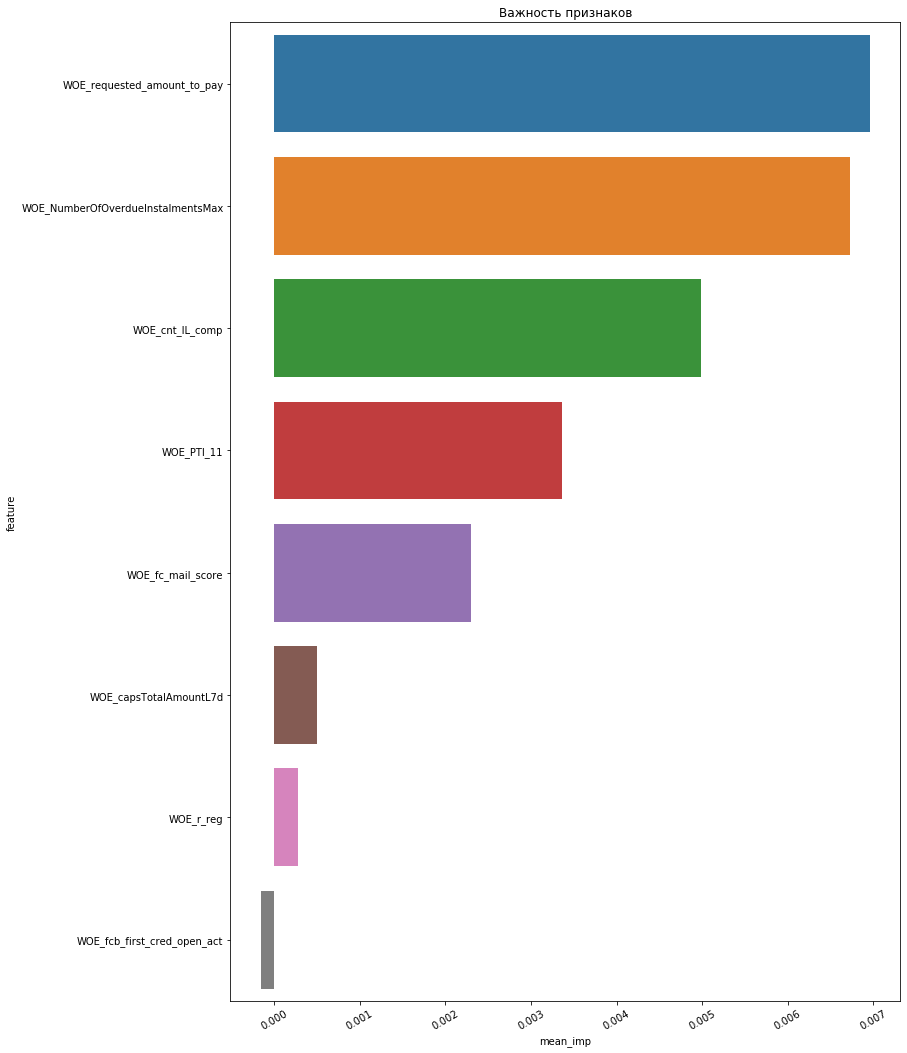

In [98]:
feature_importance = tf_imp[tf_imp['feature'].isin(vars_woe)]
feat_imp_parts = plot_feature_importances(feature_importance, pic_folder=pic_folder)

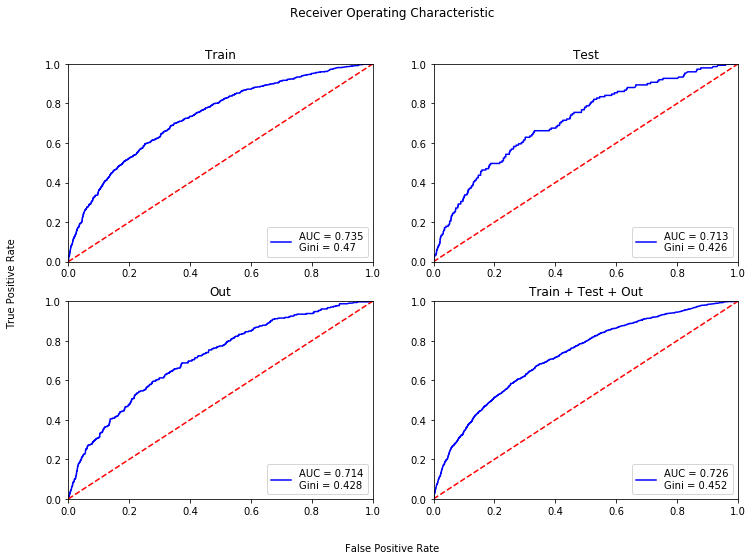

In [101]:
X_all = df3.copy()
y_all = df3['target'].copy()

plot_roc_curve(model, vars_woe, X_all, y_all, X_train, y_train, X_test, y_test,
                 X_out, y_out, pic_folder=pic_folder)

In [108]:
# Считаем однофакторный gini для train, test, out.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, vars_woe)
gini_by_vars

,vars,gini_train,gini_test,gini_out
1,WOE_cnt_IL_comp,0.267,0.278,0.293
3,WOE_capsTotalAmountL7d,0.245,0.201,0.217
0,WOE_requested_amount_to_pay,0.243,0.185,0.208
6,WOE_PTI_11,0.2,0.153,0.076
4,WOE_NumberOfOverdueInstalmentsMax,0.188,0.197,0.246
2,WOE_r_reg,0.17,0.178,0.274
5,WOE_fc_mail_score,0.161,0.149,0.035
7,WOE_fcb_first_cred_open_act,0.137,0.145,0.164


In [109]:
# Считаем однофакторный gini по месяцам.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week.
_, df_gini_months = gini_month_selection(df3[vars_woe], df3, date_name=date_name, intervals=intervals)
df_gini_months

,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
0,WOE_requested_amount_to_pay,0.196,0.275,0.222,0.327,0.328,0.192,0.186,0.192,0.214,0.198
1,WOE_cnt_IL_comp,0.178,0.074,0.325,0.238,0.306,0.306,0.262,0.346,0.330,0.249
2,WOE_r_reg,0.005,0.292,0.034,0.235,0.161,0.169,0.222,0.188,0.249,0.307
3,WOE_capsTotalAmountL7d,0.157,0.253,0.232,0.355,0.196,0.192,0.237,0.215,0.234,0.194
4,WOE_NumberOfOverdueInstalmentsMax,0.144,0.120,0.189,0.056,0.268,0.170,0.212,0.275,0.211,0.287
5,WOE_fc_mail_score,0.113,0.059,0.110,0.148,0.171,0.130,0.180,0.108,0.050,0.018
6,WOE_PTI_11,0.151,0.139,0.179,0.273,0.345,0.048,0.206,0.159,0.046,0.113
7,WOE_fcb_first_cred_open_act,0.158,0.220,0.116,0.150,0.115,0.120,0.105,0.163,0.093,0.249


In [111]:
# Create ivi to excel
ivs = ivs_to_excel(iv_df, X_train[vars_woe])

# Score and IV groups
ivs = iv_groups(ivs)
# ivs = add_score(ivs, feat, y_train)
feat = pd.DataFrame(vars_woe, columns=['Feature'])

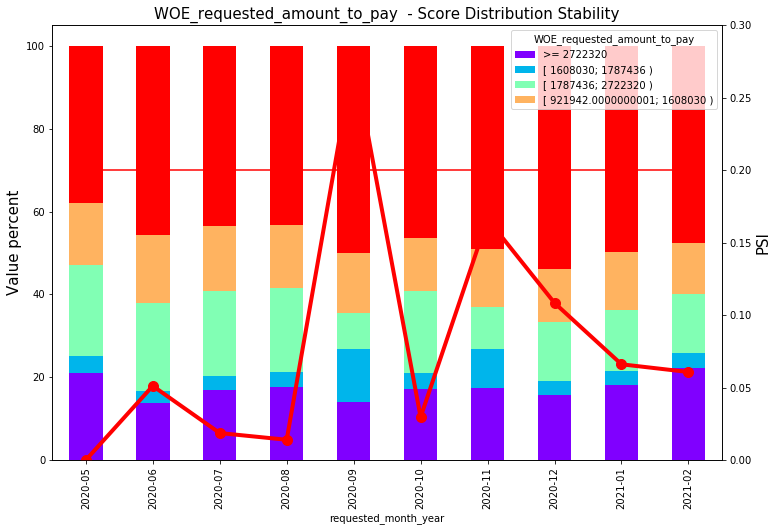

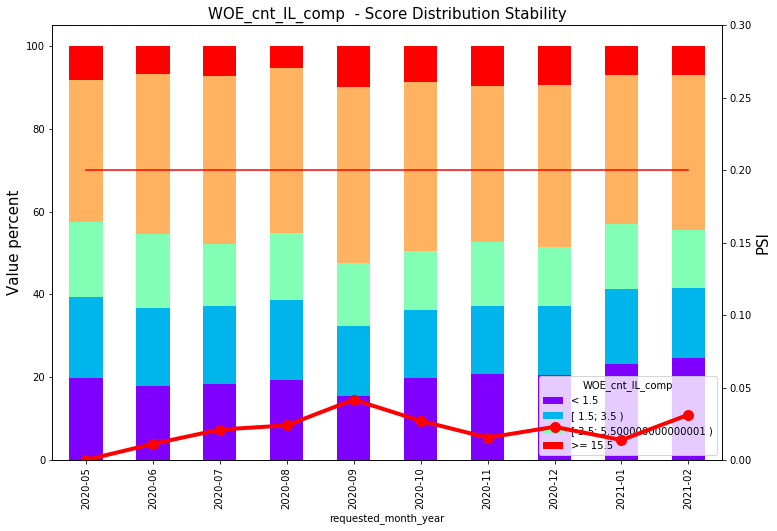

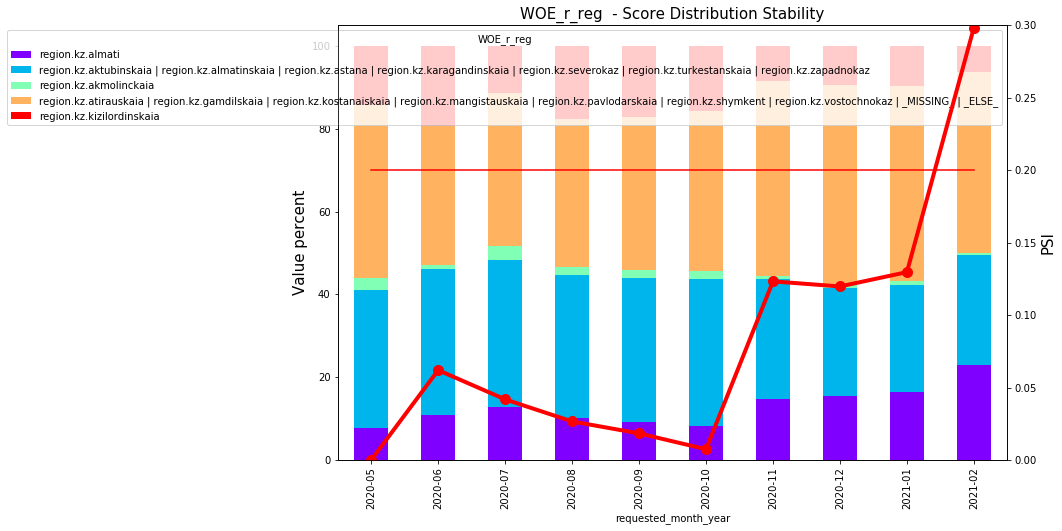

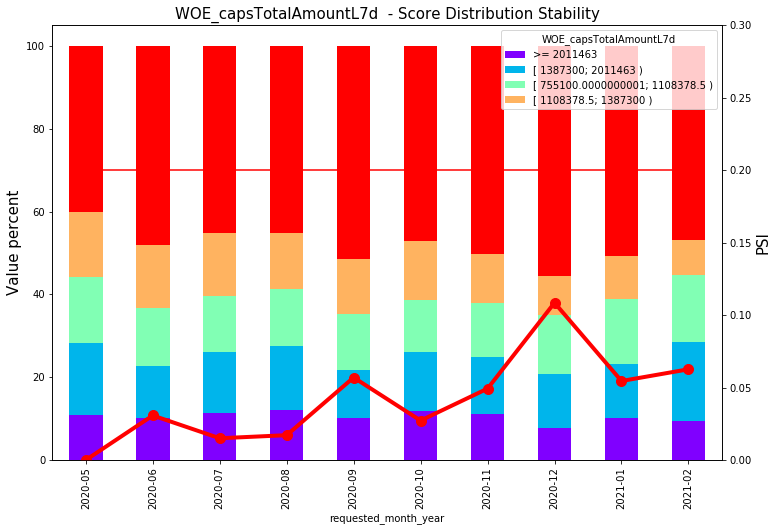

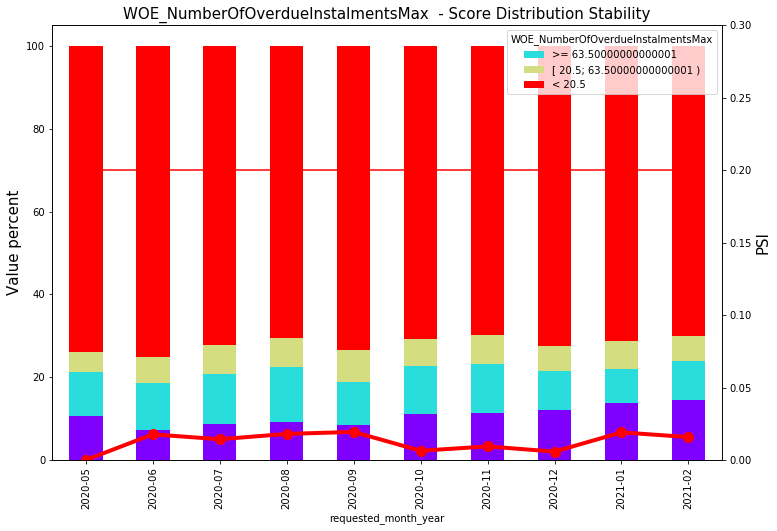

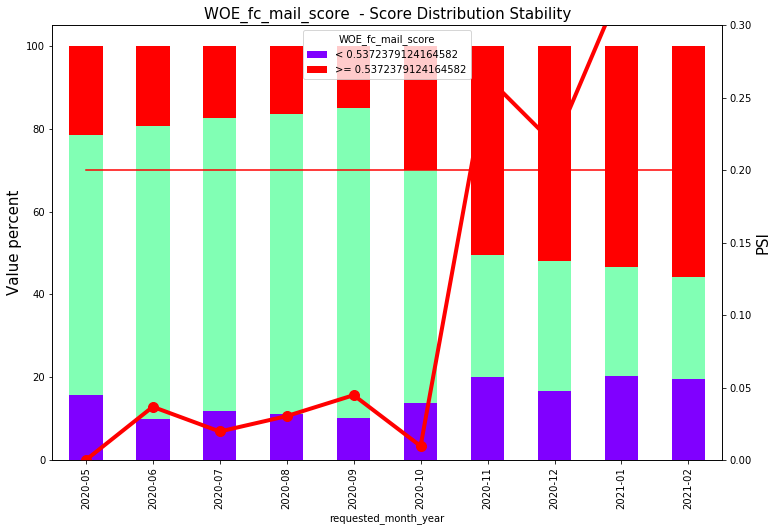

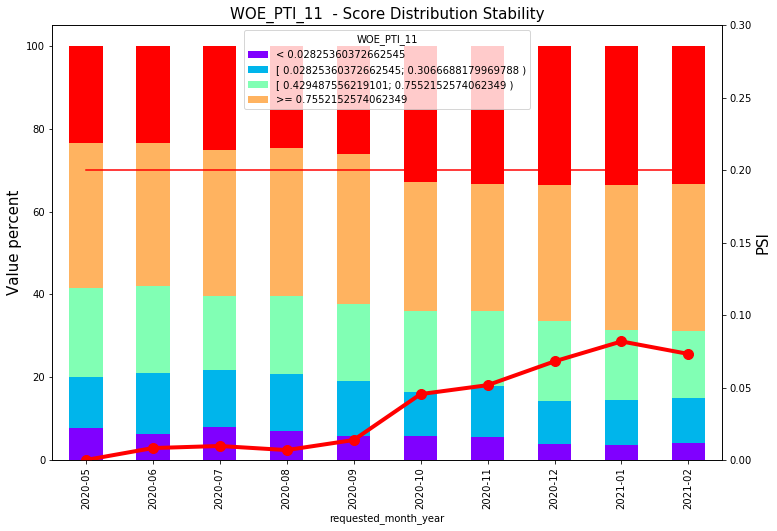

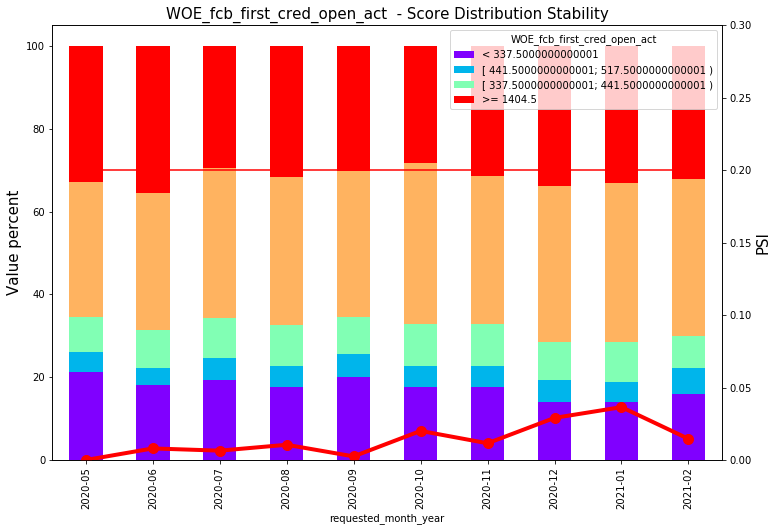

In [112]:
month_num = 0  # Номер месяца от которого отталкиваться в расчёте psi.
date_name = DATE  # имя столбца даты по которому делить на месяцы
features_of_model = population_stability(df3, ivs, feat, month_num=month_num, pic_folder=pic_folder, date_name=date_name)

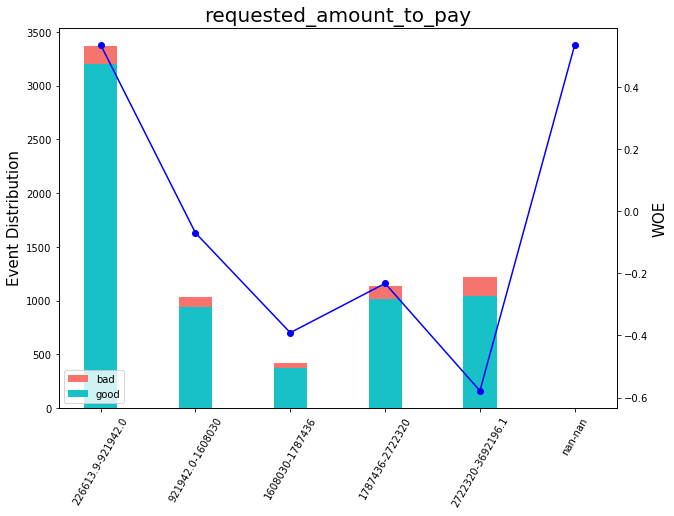

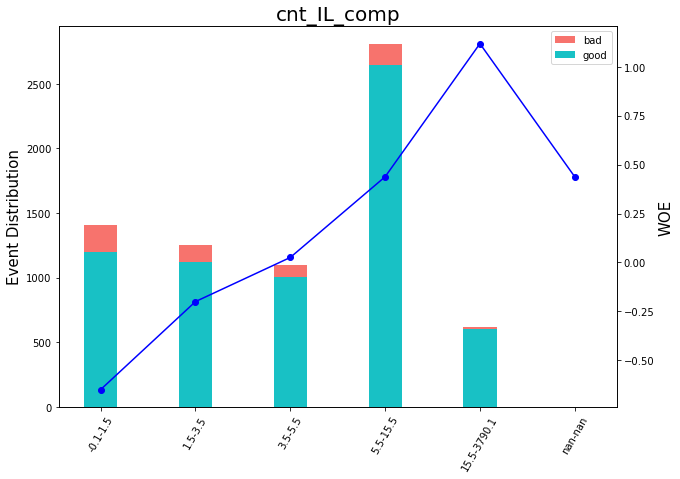

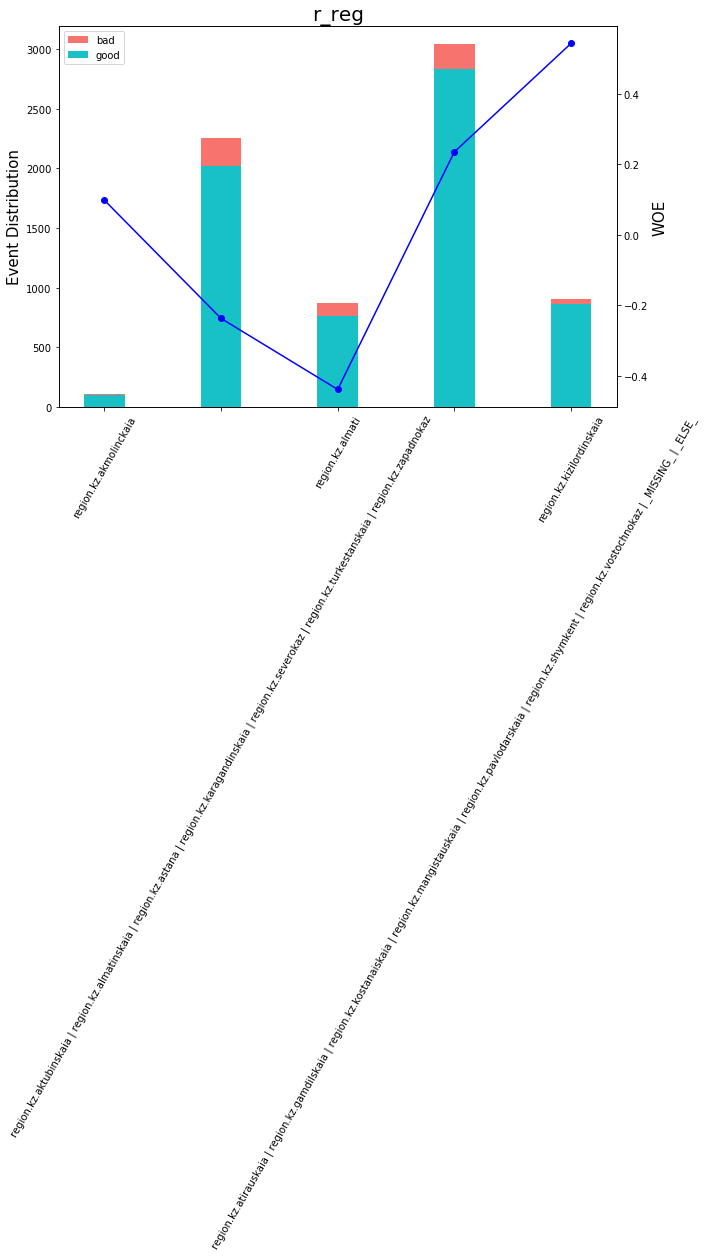

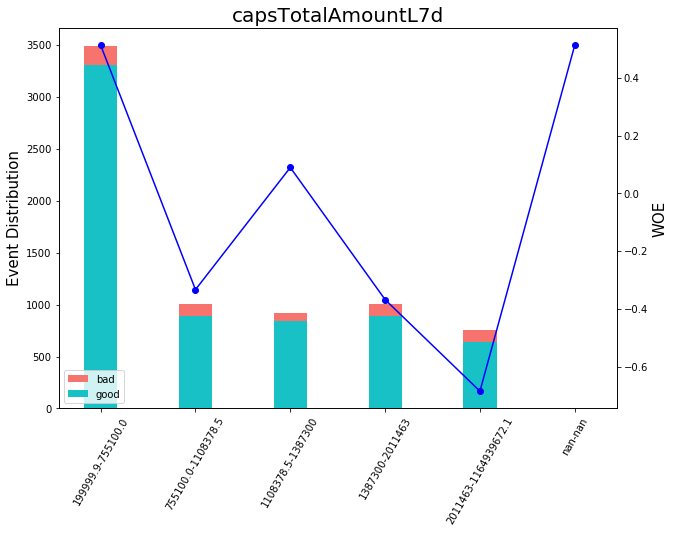

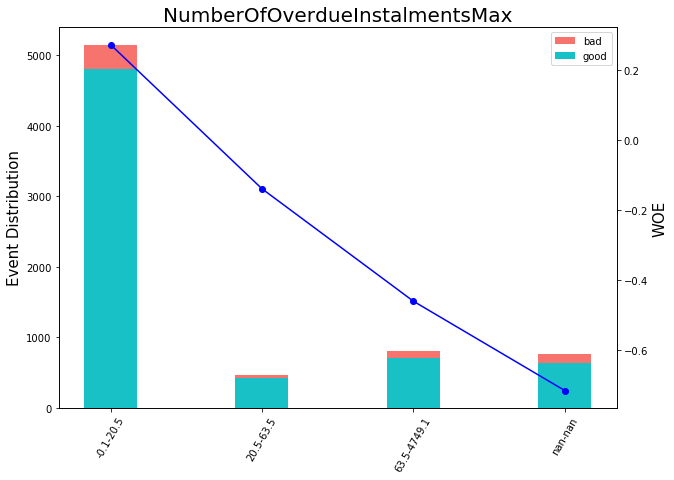

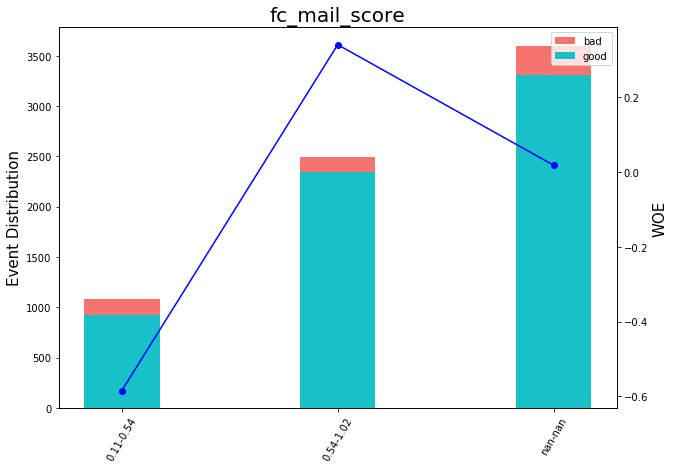

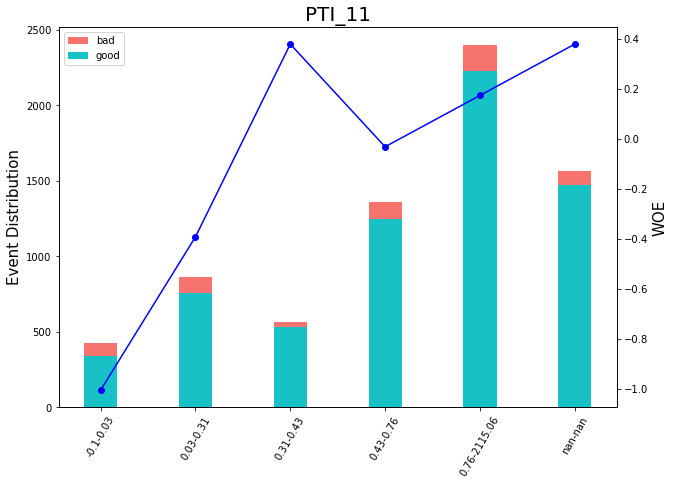

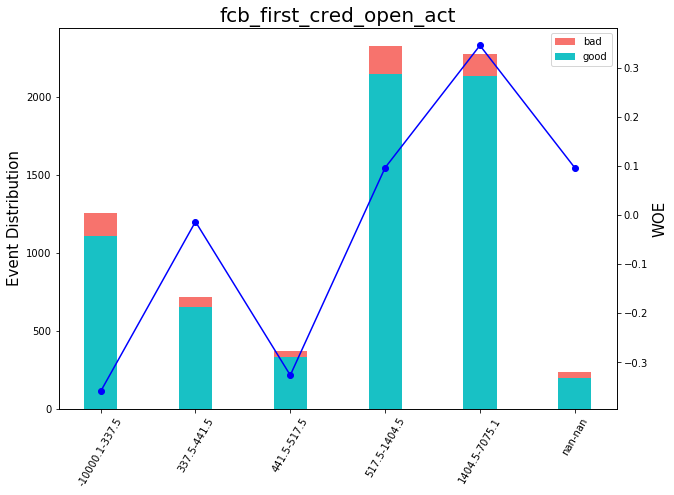

In [113]:
plot_all_bins(iv_df, X_train[vars_woe], pic_folder=pic_folder)

#### Формирование итогового excel файла

In [ ]:
model = sm.Logit(y_train, X_train[vars_woe])
model_fit = model.fit()
model_fit.pvalues

PV = pd.DataFrame(data=model_fit.pvalues, columns=['pv_train'])
PV = PV.sort_values(by='pv_train', ascending=False)
# PV.to_excel('results/pvalues.xlsx')

Optimization terminated successfully.
         Current function value: 0.582207
         Iterations 5


In [117]:
target_description = 'npl1_3mob'
model_description = 'Скоркарта Solva KZ сегмента street'

DSL = ''

if type(model) == LinearTreeClassifier:
    SQL = convert_linear_tree_to_sql(model, vars_woe, iv_df)
elif type(model) in (DecisionTreeClassifier, RandomForestClassifier):
    SQL = convert_model_to_sql(model, vars_woe, iv_df)

name_2 = 'report/slkz_solvaStreet_score_model_v1.1'

export_to_excel_model(
    X_train=X_train[vars_woe],
    X_test=X_test[vars_woe],
    y_train=y_train,
    y_test=y_test,
    y=y,
    df3=df3,
    iv_df=iv_df,
    Ginis=Ginis,
    table=table,
    scores=scores,
    feat=vars_woe,
    clf_lr=model,
    ivs=ivs,
    df_gini_months=df_gini_months,
    DSL=DSL,
    SQL=SQL,
    X_out=X_out[vars_woe],
    y_out=y_out,
    name=name_2,
    pic_folder='pic/',
    target_description=target_description,
    model_description=model_description,
    date_name='date_requested'
)

Exported!
